####데이터 전처리
1. 데이터 로드
2. 데이터 컬럼 rename
3. 데이터 time 인덱스 변환
4. 송화인, 수화인 주소별 터미널 위치 매치

In [170]:
!pip install haversine
!pip install pyarrow

In [159]:
import plotly.io.orca
import pandas as pd
import numpy as np 
import datetime
import plotly
import plotly.graph_objs as go # 그래프 객체 생성
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import warnings
import folium
from folium import plugins
from haversine import haversine
from sklearn.cluster import KMeans
import seaborn as sns

warnings.filterwarnings(action='ignore')
 
##set jupyter_notebook_config.py, c.NotebookApp.max_buffer_size = 1000000000; c.NotebookApp.max_body_size = 1000000000


In [25]:
### 로컬로 가져갈 시 변경될 코드
## 터미널 데이터 출처

PATH = "./server/data/"
ETC = "./server/data/2. 미래기술 챌린지 제공 Data(참고).xlsx"
TERMINAL = "./server/data/HubLocation.xlsx"
LOCATION = "./server/data/시군구_위도_경도.csv"


In [135]:
### 데이터 로드

e_commerce_fc_3 = pd.read_feather(PATH + "fc_3.ftr", columns=["CORP_ID", "BKG_DATE", "BKG_TIME", "SHPR_CD", "ITEM_QTY", "ITEM_AMT", "INS_ID", "POST_ZONE", "SHPR_ADDR_1", "SHPR_ADDR_2", "CNEE_ADDR_1", "CNEE_ADDR_2"])
e_commerce_fc_4 = pd.read_feather(PATH + "fc_4.ftr", columns=["CORP_ID", "BKG_DATE", "BKG_TIME", "SHPR_CD", "ITEM_QTY", "ITEM_AMT", "INS_ID", "POST_ZONE", "SHPR_ADDR_1", "SHPR_ADDR_2", "CNEE_ADDR_1", "CNEE_ADDR_2"])
e_commerce_fc_5 = pd.read_feather(PATH + "fc_5.ftr", columns=["CORP_ID", "BKG_DATE", "BKG_TIME", "SHPR_CD", "ITEM_QTY", "ITEM_AMT", "INS_ID", "POST_ZONE", "SHPR_ADDR_1", "SHPR_ADDR_2", "CNEE_ADDR_1", "CNEE_ADDR_2"])
e_commerce_fc_6 = pd.read_feather(PATH + "fc_6.ftr", columns=["CORP_ID", "BKG_DATE", "BKG_TIME", "SHPR_CD", "ITEM_QTY", "ITEM_AMT", "INS_ID", "POST_ZONE", "SHPR_ADDR_1", "SHPR_ADDR_2", "CNEE_ADDR_1", "CNEE_ADDR_2"])

info = pd.read_excel(ETC)


In [137]:
e_commerce_fc_data = pd.concat([e_commerce_fc_3, e_commerce_fc_4, e_commerce_fc_5, e_commerce_fc_6])
e_commerce_fc_data.reset_index(inplace=True)
e_commerce_fc_data. drop("index",  axis=1, inplace=True)

In [138]:
len(e_commerce_fc_data)

1786374

In [139]:
### 데이터 컬럼 rename

info_list_eng = info["Unnamed: 1"]
info_list_kr = info["Unnamed: 2"]

info_list_eng = info_list_eng.drop(labels=[12, 20])
info_list_kr = info_list_kr.drop(labels=[12, 20])

column_dict = {}

for eng, kr in zip(info_list_eng, info_list_kr):
  column_dict[eng] = kr

e_commerce_fc_data.rename(columns = column_dict, inplace=True)
e_commerce_fc_data.rename(columns = {
    "창고코드(KX007: 곤지암, GP001: 군포)" : "참고초드", 
    "고객 주문번호, 해당 테이블 key값, 네이버 채번" : "고객주문번호", 
    "주문유형(7: B2C출고, 8: 정상반출, 9: 불량반출)" : "주문유형" 
}, inplace=True)

e_commerce_fc_data.rename(columns = {
    "CJ대한통운 주문번호(예약번호)" : "주문번호", 
    "입력일자(인터페이스 시간)" : "입력일자", 
    "입력시간(인터페이스시간)" : "입력시간", 
    "SHPR_ADDR_1" : "송화인주소1", 
    "SHPR_ADDR_2" : "송화인주소2", 
    "CNEE_ADDR_1" : "수화인주소1", 
    "CNEE_ADDR_2" : "수화인주소2"
}, inplace=True)



In [140]:
e_commerce_fc_data.keys()

Index(['참고초드', '주문 날짜', '주문 시간', '고객사코드', '품목수량', '품목금액', '입력자ID', '권역구분',
       '송화인주소1', '송화인주소2', '수화인주소1', '수화인주소2'],
      dtype='object')

In [31]:
e_commerce_fc_data.shape

(1786374, 11)

In [32]:
### 데이터 주문 날짜, 주문 시간 중심으로 데이터 index 설정

time_list = []
for i in range(len(e_commerce_fc_data)):
    days = str(e_commerce_fc_data["주문 날짜"][i])
    year = days[:4]
    month = days[4:6]
    day = days[6:]

    length = len(str(e_commerce_fc_data["주문 시간"][i]))
    str_time = str(e_commerce_fc_data["주문 시간"][i])
    if length == 1:
        times = "00000" + str_time
    elif length == 2:
        times = "0000" + str_time
    elif length == 3:
        times = "000" + str_time
    elif length == 4:
        times = "00" + str_time
    elif length == 5:
        times = "0" + str_time
    else:
        times = str_time

    h = times[:2]
    m = times[2:4]
    s = times[4:6]
    time_list.append(datetime.datetime(int(year), int(month), int(day), int(h), int(m), int(s)))

e_commerce_fc_data.index = time_list
e_commerce_fc_data["datetime"] = time_list

In [33]:
e_commerce_fc_data.head(1)

참고초드     주문 날짜  주문 시간     고객사코드  품목수량     품목금액  권역구분  \
2021-03-03 03:55:10  KX007  20210303  35510  90001302     1  14900.0   3.0   

                      송화인주소1 송화인주소2 수화인주소1 수화인주소2            datetime  
2021-03-03 03:55:10  세종특별자치시   None  서울특별시   서대문구 2021-03-03 03:55:10

In [34]:
### 송화인 수화인 주소별 터미널 매치
e_commerce_fc_data = e_commerce_fc_data.dropna(subset=["수화인주소1"])

In [35]:
get_terminal = {}

## json 파일로 변환해서 읽어오기
get_terminal["서울"] = "서울특별시"
get_terminal["경기도"] = "경기도"
get_terminal["서울특별시"] = "서울특별시"
get_terminal["대구광역시"] = "대구광역시"
get_terminal["인천광역시"] = "인천광역시"
get_terminal["충청북도"] = "충청북도"
get_terminal["경상북도"] = "경상북도"
get_terminal["경상남도"] = "경상남도"
get_terminal["부산광역시"] = "부산광역시"
get_terminal["전라북도"] = "전라북도"
get_terminal["대전광역시"] = "대전광역시"
get_terminal["충청남도"] = "충청남도"
get_terminal["강원도"] = "강원도"
get_terminal["전라남도"] = "전라남도"
get_terminal["세종특별자치시"] = "세종특별자치시"
get_terminal["울산광역시"] = "울산광역시"
get_terminal["광주광역시"] = "광주광역시"
get_terminal["강원"] = "강원도"
get_terminal["제주특별자치도"] = "제주특별자치도"
get_terminal["충북"] = "충청북도"
get_terminal["경기"] = "경기도"
get_terminal["부산"] = "부산광역시"
get_terminal["대구"] = "대구광역시"
get_terminal["대전"] = "대전광역시"
get_terminal["인천"] = "인천광역시"
get_terminal["경남"] = "경상남도"
get_terminal["경기도수원시"] = "수원시"
get_terminal["전남"] = "전라남도"
get_terminal["전북"] = "전라북도"
get_terminal["충남"] = "충청남도"
get_terminal["경북"] = "경상북도"
get_terminal["광주"] = "광주광역시"
get_terminal["울산"] = "울산광역시"
get_terminal["부산시"] = "부산광역시"
get_terminal["인천시"] = "인천광역시"
get_terminal["서울시"] = "서울특별시"
get_terminal["제주"] = "제주특별자치도"
get_terminal["세종"] = "세종특별자치시"
get_terminal["\u200b서울시"] = "서울특별시"
get_terminal["강서구"] = "서울특별시 강서구"
get_terminal["대구시"] = "대구광역시"
get_terminal["청주시"] = "충청북도 청주시"
get_terminal["\t경기도"] = "경기도"
get_terminal["충남금산군"] = "충청남도"
get_terminal["전남목포시"] = "전라남도"

get_terminal_1 = []

for terminal in e_commerce_fc_data["수화인주소1"] : 
    if terminal != None : 
        try:            
            get_terminal_1.append(get_terminal[terminal]) 
        except:
            get_terminal_1.append("없음")

send_terminal = {}

send_terminal["경기도"] = "경기도"
send_terminal["경기"] = "경기도"

send_terminal_1 = []

for terminal in e_commerce_fc_data["송화인주소1"] : 
  if terminal == "경기도" or terminal == "경기" : 
    send_terminal_1.append(send_terminal[terminal])
  else : 
    send_terminal_1.append(terminal)

send_terminal_2 = e_commerce_fc_data["송화인주소2"]
get_terminal_2 = e_commerce_fc_data["수화인주소2"]


send_spot = []
get_spot = []

for send1, send2, get1, get2 in zip(send_terminal_1, send_terminal_2, get_terminal_1, get_terminal_2) :
  send_result = "%s %s" %(send1, send2)
  get_result = "%s %s" %(get1, get2)
  send_spot.append(send_result)
  get_spot.append(get_result)


e_commerce_fc_data['송화인터미널'] = send_spot
e_commerce_fc_data["수화인터미널"] = get_spot

In [39]:
terminal_info = pd.read_excel(TERMINAL, sheet_name=0)
location_info = pd.read_csv(LOCATION)

In [40]:
terminal_info.head(5)

Hub                  Location  Latitude  Longitude
0  MegaHub곤지암    경기도 광주시 초월읍 산수로 642-70    37.384    127.314
1       군포Hub         경기도 군포시 부곡동 451번지    37.331    126.938
2       대전Hub   대전광역시 대덕구 대덕대로1447번길 39    36.449    127.408
3       옥천Hub      충청북도 옥천군 이원면 건진2길 65    36.252    127.624
4       용인Hub  경기도 용인시 처인구 원삼면 미평리 75번지    37.183    127.327

In [41]:
location_info.head(5)

시군구       위도        경도
0  서울특별시 종로구  37.5730  126.9794
1   서울특별시 중구  37.5641  126.9979
2  서울특별시 용산구  37.5384  126.9654
3  서울특별시 성동구  37.5633  127.0371
4  서울특별시 광진구  37.5385  127.0823

In [42]:
# e_commerce_fc_data["송화인터미널"].unique()

# 곤지암 Hub
HUB_GONJIAM = terminal_info[terminal_info["Hub"] == "MegaHub곤지암"]
HUB_GONJIAM_LATITUDE = HUB_GONJIAM["Latitude"].iloc[0]
HUB_GONJIAM_LONGITUDE = HUB_GONJIAM["Longitude"].iloc[0]

# 군포 Hub

HUB_GUNPO = terminal_info[terminal_info["Hub"] == "군포Hub"]
HUB_GUNPO_LATITUDE = HUB_GUNPO["Latitude"].iloc[0]
HUB_GUNPO_LONGITUDE = HUB_GUNPO["Longitude"].iloc[0]

In [43]:
HUB_GUNPO["Longitude"].iloc[0]

126.938

In [44]:
terminal_hub_dict = terminal_info.to_dict()["Hub"]
terminal_latitude_dict = terminal_info.to_dict()["Latitude"]
terminal_longitude_dict = terminal_info.to_dict()["Longitude"]

terminal_hub_swap = {k : v for v, k in terminal_hub_dict.items()}

send_terminal_result = {}

send_terminal_result['세종특별자치시 nan'] = "세종Sub"
send_terminal_result['경기도 광주시'] = "분당ASub"
send_terminal_result["경기도 고양시"] = "파주Sub"
send_terminal_result["경기도 포천시"] = "포천Sub"
send_terminal_result["경기도 안산시"] = "경기도 안산시"
send_terminal_result["충청북도 청주시"] = "흥덕Sub"
send_terminal_result['서울특별시 금천구'] = "금천Sub"
send_terminal_result["경기도 이천시"] = "이천Sub"
send_terminal_result["충청북도 충주시"] = "충주Sub"
send_terminal_result["충청남도 보령시"] = "보령Sub"
send_terminal_result["경기도 용인시"] = "용인Hub"
send_terminal_result["경기도 안성시"] = "안성Sub"
send_terminal_result["충청남도 천안시"] = "천안서Sub"
send_terminal_result["충청남도 당진시"] = "당진Sub"
send_terminal_result["경기도 평택시"] = "평택BSub"
send_terminal_result["경기도 군포시"] = "군포Sub"

send_latitudes_list = []
send_longitudes_list = []
send_hubs_list = []

count = 0

for send_terminal in e_commerce_fc_data["송화인터미널"] :
  if send_terminal == "경기도 안산시" :
    latitude = location_info[location_info["시군구"] == "경기도 안산시"]["위도"].iloc[0]
    longitude = location_info[location_info["시군구"] == "경기도 안산시"]["경도"].iloc[0]
    hub = "안산시청"
  else :
    if send_terminal not in send_terminal_result.keys():
        latitude = 0
        longitude = 0
        hub = "없음"
    else:
        # latitude = terminal_info[terminal_info["Hub"] == send_terminal_result[send_terminal]]["Latitude"].iloc[0]
        # longitude = terminal_info[terminal_info["Hub"] == send_terminal_result[send_terminal]]["Longitude"].iloc[0]
        # hub = terminal_info[terminal_info["Hub"] == send_terminal_result[send_terminal]]["Hub"].iloc[0]

        latitude = terminal_latitude_dict[terminal_hub_swap[send_terminal_result[send_terminal]]]
        longitude = terminal_longitude_dict[terminal_hub_swap[send_terminal_result[send_terminal]]]
        hub = send_terminal_result[send_terminal]
        # print(terminal_info[terminal_info["Hub"] == send_terminal_result[send_terminal]])
        # break



  send_latitudes_list.append(latitude)
  send_longitudes_list.append(longitude)
  send_hubs_list.append(hub)


In [45]:
location_dict = location_info.to_dict()["시군구"]
location_latitude_dict = location_info.to_dict()["위도"]
location_longitude_dict = location_info.to_dict()["경도"]

location_dict_swap = {k : v for v, k in location_dict.items()}

location_result_dict = {}

for location, hub in zip(terminal_info["Location"], terminal_info["Hub"]) : 
  split_location_info = location.split(" ")
  big_location = split_location_info[0] + " " + split_location_info[1]

  keys = location_result_dict.get(big_location, [])
  keys.append(hub)

  location_result_dict[big_location] = keys

latitudes = []
longitudes = []
location = []


for get_terminal in e_commerce_fc_data["수화인터미널"] : 
  terminal = location_result_dict.get(get_terminal, "시청")

  if terminal == "시청" :

    if get_terminal in location_dict_swap.keys():   

      location.append(get_terminal)
      latitudes.append(location_latitude_dict[location_dict_swap[get_terminal]])      
      longitudes.append(location_longitude_dict[location_dict_swap[get_terminal]])  

    elif "세종특별자치시" in get_terminal: 
      location.append("세종Sub")
      latitudes.append(36.544)
      longitudes.append(127.357)
    else :  
      location.append("매치 x")
      latitudes.append(0)
      longitudes.append(0)
  else : 

    location.append(terminal[-1])    
    latitudes.append(terminal_latitude_dict[terminal_hub_swap[terminal[-1]]])
    longitudes.append(terminal_longitude_dict[terminal_hub_swap[terminal[-1]]])






In [46]:
print("latitudes_list", len(send_latitudes_list))
print("latitudes_list2", len(latitudes))
print("length df", len(e_commerce_fc_data))

latitudes_list 1786339
latitudes_list2 1786339
length df 1786339


In [47]:
e_commerce_fc_data["SHPR_ADDR_LATITUDE"] =  send_latitudes_list
e_commerce_fc_data["SHPR_ADDR_LONGITUDE"] =  send_longitudes_list
e_commerce_fc_data["SHPR_ADDR_HUBS"] = send_hubs_list

e_commerce_fc_data["CNEE_ADDR_LATITUDE"] =  latitudes
e_commerce_fc_data["CNEE_ADDR_LONGITUDE"] =  longitudes
e_commerce_fc_data["CNEE_ADDR_HUBS"] = location

In [48]:
e_commerce_fc_data = e_commerce_fc_data[(e_commerce_fc_data["SHPR_ADDR_LATITUDE"] != 0) &
                                        (e_commerce_fc_data["SHPR_ADDR_LONGITUDE"] != 0) &
                                        (e_commerce_fc_data["CNEE_ADDR_LATITUDE"] != 0) &
                                        (e_commerce_fc_data["CNEE_ADDR_HUBS"] != 0)
                                        ]

In [49]:
e_commerce_fc_data.head(1)

참고초드     주문 날짜  주문 시간     고객사코드  품목수량     품목금액  권역구분  \
2021-03-03 03:55:21  KX007  20210303  35521  90001441     1  20900.0  50.0   

                    송화인주소1 송화인주소2 수화인주소1 수화인주소2            datetime   송화인터미널  \
2021-03-03 03:55:21    경기도    광주시   경상남도    김해시 2021-03-03 03:55:21  경기도 광주시   

                       수화인터미널  SHPR_ADDR_LATITUDE  SHPR_ADDR_LONGITUDE  \
2021-03-03 03:55:21  경상남도 김해시              37.403              127.239   

                    SHPR_ADDR_HUBS  CNEE_ADDR_LATITUDE  CNEE_ADDR_LONGITUDE  \
2021-03-03 03:55:21         분당ASub              35.236              128.831   

                    CNEE_ADDR_HUBS  
2021-03-03 03:55:21         김해ASub

In [50]:
e_commerce_fc_data.keys()

Index(['참고초드', '주문 날짜', '주문 시간', '고객사코드', '품목수량', '품목금액', '권역구분', '송화인주소1',
       '송화인주소2', '수화인주소1', '수화인주소2', 'datetime', '송화인터미널', '수화인터미널',
       'SHPR_ADDR_LATITUDE', 'SHPR_ADDR_LONGITUDE', 'SHPR_ADDR_HUBS',
       'CNEE_ADDR_LATITUDE', 'CNEE_ADDR_LONGITUDE', 'CNEE_ADDR_HUBS'],
      dtype='object')

In [51]:
len(e_commerce_fc_data)

1638830

In [52]:
e_commerce_fc_data["SHPR_ADDR_LATITUDE"].unique()

array([37.403 , 37.726 , 37.883 , 36.659 , 37.3219, 37.472 , 37.228 ,
       36.991 , 36.323 , 37.331 , 37.183 , 37.012 , 36.871 , 36.884 ,
       36.992 ])

####데이터 EDA
1. 시간별 데이터
- 일별
- 시간별
2. 거리별 시각화
- 터미널 지도
- 직선거리 데이터와 길찾기 데이터 보정값 비교
- 택배배달 분포 (?)
3. 상온 상품 같은 요소 확인
- 입력자ID 중 음식 인 것들
4. 권역별 시각화 
- 권역별 배달 TOP10 
- TOP10 지역의 시간별 배송량 차이



1. 시간별 데이터
- day_data_count = 일별 택배배송량 카운트
- hour_data_count = 시간별 택배배송량 카운트

In [53]:
day_data_count = e_commerce_fc_data.resample("D").count()[["품목수량"]]
hour_data_count = e_commerce_fc_data.resample("1H").count()[["품목수량"]]

In [56]:
# day_data_count.reset_index().to_feather("./server/data/fc_1d.ftr")
# hour_data_count.reset_index().to_feather("./server/data/fc_1h.ftr")


In [150]:
max_count = day_data_count["품목수량"].max()
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Scatter(x=day_data_count.index, y=day_data_count['품목수량'], mode='lines+markers', name='배송량'), secondary_y=False)

for i in range(3, 7):
    fig.add_trace(go.Scatter(
                x=[pd.to_datetime('2021-0' + str(i) +'-02')],
                y=[max_count+1000],
                mode='text', 
                text = str(i) + "월",
                name = str(i) + "월"
                )
    )
    
    fig.add_shape(
            dict(
                type="line",
                name = str(i) + "월",
                x0=pd.to_datetime('2021-0' + str(i) +'-01'),
                y0=-10,
                x1=pd.to_datetime('2021-0' + str(i) +'-01'),
                y1=max_count,
                line=dict(
                    color="black",
                    width=3,
                    dash='dashdot'

                )
    ))

fig.update_layout(
    title = "일별 배송량",
    autosize=False,
    width=1000, 
    height=400,
    margin = dict(
        l=5,
        r=10,
        b=10,
        t=40
    ),
    paper_bgcolor="LightSteelBlue"
    )


fig.show()

In [58]:
max_count = hour_data_count["품목수량"].max()
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Scatter(x=hour_data_count.index, y=hour_data_count['품목수량'], mode='lines', name='배송량'), secondary_y=False)

for i in range(3, 7):
    fig.add_trace(go.Scatter(
                x=[pd.to_datetime('2021-0' + str(i) +'-02')],
                y=[max_count+1000],
                mode='text', 
                text = str(i) + "월",
                name = str(i) + "월"
                )
    )
    
    fig.add_shape(
            dict(
                type="line",
                name = str(i) + "월",
                x0=pd.to_datetime('2021-0' + str(i) +'-01'),
                y0=-10,
                x1=pd.to_datetime('2021-0' + str(i) +'-01'),
                y1=max_count,
                line=dict(
                    color="black",
                    width=3,
                    dash='dashdot'

                )
    ))

fig.update_layout(
    title = "시간별 배송량",
    autosize=False,
    width=1000, 
    height=400,
    margin = dict(
        l=5,
        r=10,
        b=10,
        t=40
    ),
    paper_bgcolor="LightSteelBlue"
    )


fig.show()

In [59]:
hour_data_count_3 = hour_data_count[hour_data_count.index.get_level_values(0) < datetime.datetime(2021, 4, 1)]
hour_data_count_4 = hour_data_count[(hour_data_count.index.get_level_values(0) >= datetime.datetime(2021, 4, 1)) & (hour_data_count.index.get_level_values(0) < datetime.datetime(2021, 5, 1))]
hour_data_count_5 = hour_data_count[(hour_data_count.index.get_level_values(0) >= datetime.datetime(2021, 5, 1)) & (hour_data_count.index.get_level_values(0) < datetime.datetime(2021, 6, 1))]
hour_data_count_6 = hour_data_count[(hour_data_count.index.get_level_values(0) >= datetime.datetime(2021, 6, 1))]


In [144]:

hour_data_list = [hour_data_count_3, hour_data_count_4, hour_data_count_5, hour_data_count_6]

fig = make_subplots(specs=[[{"secondary_y": True}]])

count = 3
visible_ = None
for i in hour_data_list:
    fig.add_trace(go.Scatter(x=[i.index.day, i.index.hour], y=i['품목수량'], mode='lines', name= str(count) + "월 배송량", visible = visible_), )
    count = count + 1
    visible_ = "legendonly"

fig.update_layout(
    title = "월별 시간별 배송량",
    autosize=False,
    width=1000, 
    height=400,
    margin = dict(
        l=5,
        r=10,
        b=10,
        t=40
    ),
    paper_bgcolor="LightSteelBlue"
    )


fig.show()

In [61]:
### 3~6 통합 시간별 최대 주문량 
time_count_dict = {}
for i in hour_data_list:
    for j in range(len(i)):
        try:
            time_count_dict[str(i.index.hour[j]) + "시"] = time_count_dict[str(i.index.hour[j]) + "시"] + i["품목수량"][j]
        except:
            time_count_dict[str(i.index.hour[j]) + "시"] = i["품목수량"][j]


time_count_df = pd.DataFrame(time_count_dict.values(), index = time_count_dict.keys(), columns = ["품목수량"])
time_count_df_sort = time_count_df.sort_values(by="품목수량", ascending=False)

In [62]:
fig = px.bar(time_count_df, x=time_count_df.index, y=time_count_df["품목수량"], color="품목수량", text="품목수량", title="시간별 배송량",  width = 800)
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.show()

In [63]:
### 3~6 통합 일별 최대 주문량 
day_count_dict = {}
type(day_data_count)

for j in range(len(day_data_count)):
    try:
        day_count_dict[str(day_data_count.index.day[j]) + "일"] = day_count_dict[str(day_data_count.index.day[j]) + "일"] + day_data_count["품목수량"][j]
    except:
        day_count_dict[str(day_data_count.index.day[j]) + "일"] = day_data_count["품목수량"][j]


day_count_dict_df = pd.DataFrame(day_count_dict.values(), index = day_count_dict.keys(), columns = ["품목수량"])
day_count_dict_df_sort = day_count_dict_df.sort_values(by="품목수량", ascending=False)

In [64]:
fig = px.bar(day_count_dict_df, x=day_count_dict_df.index, y=day_count_dict_df["품목수량"], color="품목수량", text="품목수량", title="일별 배송량", width = 800)
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.show()

## 주중, 주말 택배량 비교

2. 거리별 시각화
- 랜덤 좌표 별 터미널 지도
- 직선거리 데이터와 길찾기 데이터 보정값 비교
- 택배배달 분포 (?)

In [73]:
location_e_commerce = e_commerce_fc_data[["참고초드",
                                         "송화인터미널", 
                                         "수화인터미널", 
                                         'SHPR_ADDR_LATITUDE', 
                                         'SHPR_ADDR_LONGITUDE', 
                                         'SHPR_ADDR_HUBS',
                                         'CNEE_ADDR_LATITUDE', 
                                         'CNEE_ADDR_LONGITUDE', 
                                         'CNEE_ADDR_HUBS'
                                         ]]

In [74]:
location_e_commerce.head(1)

참고초드   송화인터미널    수화인터미널  SHPR_ADDR_LATITUDE  \
2021-03-03 03:55:21  KX007  경기도 광주시  경상남도 김해시              37.403   

                     SHPR_ADDR_LONGITUDE SHPR_ADDR_HUBS  CNEE_ADDR_LATITUDE  \
2021-03-03 03:55:21              127.239         분당ASub              35.236   

                     CNEE_ADDR_LONGITUDE CNEE_ADDR_HUBS  
2021-03-03 03:55:21              128.831         김해ASub

In [75]:
SHPR_set = set()
CNEE_set = set()
for i in range(len(location_e_commerce)):
    SHPR_set.add((location_e_commerce["SHPR_ADDR_LATITUDE"][i], location_e_commerce["SHPR_ADDR_LONGITUDE"][i]))
    CNEE_set.add((location_e_commerce["CNEE_ADDR_LATITUDE"][i], location_e_commerce["CNEE_ADDR_LONGITUDE"][i]))




In [76]:
len(CNEE_set)

229

In [69]:
shpr_location = pd.DataFrame(SHPR_set, columns = ["latitude", "longitude"])
cnee_location = pd.DataFrame(CNEE_set, columns = ["latitude", "longitude"])

cnee_location.head(5)

latitude  longitude
0   36.2520   127.6240
1   35.9910   126.7090
2   34.8120   126.3920
3   35.1061   129.0323
4   37.7880   128.8470

In [70]:
f = folium.Figure(width=1000, height=700)
m = folium.Map(width = 1000, height = 700, location = [37.4292, 126.9874], zoom_start = 7)
minimap = plugins.MiniMap()

all_point = folium.FeatureGroup(name='all_point')
sender_point = plugins.FeatureGroupSubGroup(all_point, 'sender_point')
receiver_point = plugins.FeatureGroupSubGroup(all_point, 'receiver_point')

m.add_child(minimap)
m.add_child(all_point)
m.add_child(sender_point)
m.add_child(receiver_point)

for i in range(len(shpr_location)):
    sender = [shpr_location["latitude"][i], shpr_location["longitude"][i]]
    folium.Circle(location = sender, radius = 50, color = "red", fill=True).add_to(sender_point)    

for i in range(len(cnee_location)):
    receiver = [cnee_location["latitude"][i], cnee_location["longitude"][i]]
    folium.Circle(location = receiver, radius = 50, color = "blue", fill=True).add_to(receiver_point)

folium.LayerControl(collapsed=False).add_to(m)
f.add_child(m)

In [71]:
center = [37.403, 127.239]	
f = folium.Figure(width=1000, height=700)
m2 = folium.Map(width = 1000, height = 700, location = center, zoom_start = 7)

folium.Circle(location = center, radius = 50000, color = "red", tooltip="50km").add_to(m2)
folium.Circle(location = center, radius = 100000, color = "red",  tooltip="100km").add_to(m2)
# folium.Circle(location = center, radius = 200000, color = "red").add_to(m2)
folium.Circle(location = center, radius = 300000, color = "red", tooltip="300km").add_to(m2)

for i in range(len(cnee_location)):
    receiver = [cnee_location["latitude"][i], cnee_location["longitude"][i]]
    folium.Circle(location = receiver, radius = 50, color = "blue", fill=True).add_to(m2)

folium.Marker(location = center).add_to(m2)    
f.add_child(m2)




In [72]:
f = folium.Figure(width=1000, height=700)

m = folium.Map(width = 1000, height = 700, location = [37.4292, 126.9874], zoom_start = 7)
minimap = plugins.MiniMap()

all_point = folium.FeatureGroup(name='all_point')
sender_point = plugins.FeatureGroupSubGroup(all_point, 'sender_point')
receiver_point = plugins.FeatureGroupSubGroup(all_point, 'receiver_point')

sender_point_radius = folium.FeatureGroup(name = "sender_point_radius", show=True)

Paju = plugins.FeatureGroupSubGroup(sender_point_radius, 'Paju', show=False)
Ansan = plugins.FeatureGroupSubGroup(sender_point_radius, 'Ansan', show=False)
Geumchun = plugins.FeatureGroupSubGroup(sender_point_radius, 'Geumchun', show=False)
Bundang = plugins.FeatureGroupSubGroup(sender_point_radius, 'Bundang', show=False)
Pochun = plugins.FeatureGroupSubGroup(sender_point_radius, 'Pochun', show=False)
Leechun = plugins.FeatureGroupSubGroup(sender_point_radius, 'Leechun', show=False)
Gunpo = plugins.FeatureGroupSubGroup(sender_point_radius, 'Gunpo', show=False)
Heungduk = plugins.FeatureGroupSubGroup(sender_point_radius, 'Heungduk', show=False)
Chungju = plugins.FeatureGroupSubGroup(sender_point_radius, 'Chungju', show=False)
Yongin = plugins.FeatureGroupSubGroup(sender_point_radius, 'Yongin', show=False)
Ansung = plugins.FeatureGroupSubGroup(sender_point_radius, 'Ansung', show=False)
Cheonan = plugins.FeatureGroupSubGroup(sender_point_radius, 'Cheonan', show=False)
Pyungtaek = plugins.FeatureGroupSubGroup(sender_point_radius, 'Pyungtaek', show=False)
Dangjin = plugins.FeatureGroupSubGroup(sender_point_radius, 'Dangjin', show=False)
Sejong = plugins.FeatureGroupSubGroup(sender_point_radius, 'Sejong', show=False)
Boryung = plugins.FeatureGroupSubGroup(sender_point_radius, 'Boryung', show=False)

shpr_plugin_list = [Paju, Ansan, Geumchun, Bundang, Pochun, Leechun, Gunpo, Heungduk, Chungju, Yongin, Ansung, Cheonan, Pyungtaek, Dangjin, Sejong, Boryung]


m.add_child(all_point)
m.add_child(sender_point)
m.add_child(receiver_point)
m.add_child(sender_point_radius)

for i in shpr_plugin_list:
    m.add_child(i)

for i in range(len(shpr_location)):
    sender = [shpr_location["latitude"][i], shpr_location["longitude"][i]]
    folium.Circle(location = sender, radius = 50, color = "red", fill=True).add_to(sender_point)    

    folium.Marker(location = sender).add_to(shpr_plugin_list[i])    
    folium.Circle(location = sender, radius = 50000, color = "red", tooltip="50km").add_to(shpr_plugin_list[i])
    folium.Circle(location = sender, radius = 100000, color = "red",  tooltip="100km").add_to(shpr_plugin_list[i])
    folium.Circle(location = sender, radius = 300000, color = "red", tooltip="300km").add_to(shpr_plugin_list[i])

for i in range(len(cnee_location)):
    receiver = [cnee_location["latitude"][i], cnee_location["longitude"][i]]
    folium.Circle(location = receiver, radius = 50, color = "blue", fill=True).add_to(receiver_point)

folium.LayerControl(collapsed=False).add_to(m)

f.add_child(m)

In [77]:
location_e_commerce.rename( columns = {"참고초드" : "창고코드"}, inplace=True)

In [78]:
location_e_commerce.keys()

Index(['창고코드', '송화인터미널', '수화인터미널', 'SHPR_ADDR_LATITUDE', 'SHPR_ADDR_LONGITUDE',
       'SHPR_ADDR_HUBS', 'CNEE_ADDR_LATITUDE', 'CNEE_ADDR_LONGITUDE',
       'CNEE_ADDR_HUBS'],
      dtype='object')

In [79]:
### 실제 거리 비교 W = 1.5
# distance = ((SHPR_terminal, megaHub) + (megaHub, CNEE_terminal)) * 1.5 

location_e_commerce["창고코드"].unique()

KX007 = (37.384, 127.314)
GP001 = (37.331, 126.938)

In [80]:
location_e_commerce.head(1)

창고코드   송화인터미널    수화인터미널  SHPR_ADDR_LATITUDE  \
2021-03-03 03:55:21  KX007  경기도 광주시  경상남도 김해시              37.403   

                     SHPR_ADDR_LONGITUDE SHPR_ADDR_HUBS  CNEE_ADDR_LATITUDE  \
2021-03-03 03:55:21              127.239         분당ASub              35.236   

                     CNEE_ADDR_LONGITUDE CNEE_ADDR_HUBS  
2021-03-03 03:55:21              128.831         김해ASub

In [81]:
distance_list = []
for i in range(len(location_e_commerce)):
    if location_e_commerce["창고코드"][i] == "KX007":
        target = KX007
    else:
        target = GP001
    location_set1 = (location_e_commerce["SHPR_ADDR_LATITUDE"][i], location_e_commerce["SHPR_ADDR_LONGITUDE"][i])
    location_set2 = (location_e_commerce["CNEE_ADDR_LATITUDE"][i], location_e_commerce["CNEE_ADDR_LONGITUDE"][i])   

    distance1 = haversine(location_set1, target)
    distance2 = haversine(target, location_set2)

    if distance1 < 30:
        distance1 = distance1 * 1.5
    elif (distance1 >= 30) and (distance1 < 100):
        distance1 = distance1 * 1.4
    elif (distance1 >= 100) and (distance1 < 200):
        distance1 = distance1 * 1.3
    else:
        distance1 = distance1 * 1.2

    if distance2 < 30:
        distance2 = distance2 * 1.5
    elif (distance2 >= 30) and (distance2 < 100):
        distance2 = distance2 * 1.4
    elif (distance2 >= 100) and (distance2 < 200):
        distance2 = distance2 * 1.3
    else:
        distance2 = distance2 * 1.2

    distance_list.append(distance1 + distance2)

location_e_commerce["distance"] = distance_list

In [82]:
location_e_commerce

창고코드   송화인터미널       수화인터미널  SHPR_ADDR_LATITUDE  \
2021-03-03 03:55:21  KX007  경기도 광주시     경상남도 김해시              37.403   
2021-03-03 03:55:13  KX007  경기도 광주시     경상남도 거제시              37.403   
2021-03-03 03:56:08  KX007  경기도 광주시    서울특별시 서초구              37.403   
2021-03-03 03:55:51  KX007  경기도 광주시      경기도 김포시              37.403   
2021-03-03 03:55:51  KX007  경기도 광주시      경기도 김포시              37.403   
...                    ...      ...          ...                 ...   
2021-06-29 12:28:12  KX007  경기도 광주시      경기도 수원시              37.403   
2021-06-30 00:02:56  KX007  경기도 광주시  제주특별자치도 제주시              37.403   
2021-06-30 14:31:18  KX007  경기도 광주시    대전광역시 유성구              37.403   
2021-06-30 22:56:53  GP001  경기도 용인시     경상남도 하동군              37.183   
2021-06-29 22:35:03  KX007  경기도 광주시   부산광역시 해운대구              37.403   

                     SHPR_ADDR_LONGITUDE SHPR_ADDR_HUBS  CNEE_ADDR_LATITUDE  \
2021-03-03 03:55:21              127.239         분당ASub             35.2360   
2021-03-03 03:55:13              127.239         분당ASub             34.8806   
2021-03-03 03:56:08              127.239         분당ASub             37.4600   
2021-03-03 03:55:51              127.239         분당ASub             37.5930   
2021-03-03 03:55:51              127.239         분당ASub             37.5930   
...                                  ...            ...                 ...   
2021-06-29 12:28:12              127.239         분당ASub             37.2636   
2021-06-30 00:02:56              127.239         분당ASub             33.4980   
2021-06-30 14:31:18              127.239         분당ASub             36.3830   
2021-06-30 22:56:53              127.327          용인Hub             35.0870   
2021-06-29 22:35:03              127.239         분당ASub             35.1631   

                     CNEE_ADDR_LONGITUDE CNEE_ADDR_HUBS    distance  
2021-03-03 03:55:21             128.8310         김해ASub  340.199185  
2021-03-03 03:55:13             128.6211       경상남도 거제시  372.945606  
2021-03-03 03:56:08             127.0390         강남BSub   49.001604  
2021-03-03 03:55:51             126.7880         김포BSub   83.095432  
2021-03-03 03:55:51             126.7880         김포BSub   83.095432  
...                                  ...            ...         ...  
2021-06-29 12:28:12             127.0286        경기도 수원시   53.283066  
2021-06-30 00:02:56             126.5240         제주BSub  536.013632  
2021-06-30 14:31:18             127.3760          유성Sub  155.307180  
2021-06-30 22:56:53             127.7290          하동Sub  364.719811  
2021-06-29 22:35:03             129.1636     부산광역시 해운대구  367.355436  

[1638830 rows x 10 columns]

In [83]:
location_e_commerce3 = location_e_commerce.groupby(["CNEE_ADDR_LATITUDE", "CNEE_ADDR_LONGITUDE"]).count()

In [84]:
location_top10 = location_e_commerce3[["수화인터미널"]].sort_values(by="수화인터미널")[-10:]
location_top20 = location_e_commerce3[["수화인터미널"]].sort_values(by="수화인터미널")[-20:]

In [85]:
location_top10.index.get_level_values(level="CNEE_ADDR_LATITUDE")

Float64Index([ 37.486, 37.5172, 37.5145,  36.659,  35.135, 37.4449,  37.726,
               37.199,   37.18, 37.2636],
             dtype='float64', name='CNEE_ADDR_LATITUDE')

In [86]:
f = folium.Figure(width=1000, height=700)
m = folium.Map(width = 1000, height = 700, location = [36.6590, 127.4650], zoom_start = 8)

size = 0
for i in range(len(location_top10)):
    size = size + 700
    sender = [location_top10.index.get_level_values(level="CNEE_ADDR_LATITUDE")[i], location_top10.index.get_level_values(level="CNEE_ADDR_LONGITUDE")[i]]
    folium.Circle(location = sender, radius = size, color = "red", fill=True).add_to(m)    

f.add_child(m)

In [87]:
f = folium.Figure(width=1000, height=700)
m = folium.Map(width = 1000, height = 700, location = [36.6590, 127.4650], zoom_start = 8)

size = 0
for i in range(len(location_top20)):
    size = size + 400
    sender = [location_top20.index.get_level_values(level="CNEE_ADDR_LATITUDE")[i], location_top20.index.get_level_values(level="CNEE_ADDR_LONGITUDE")[i]]
    folium.Circle(location = sender, radius = size, color = "red", fill=True).add_to(m)    

f.add_child(m)

3. 상온 상품 같은 요소 확인
- 입력자ID 중 음식 인 것들


In [88]:
groupby_c_code = e_commerce_fc_data.groupby("고객사코드").count()[["품목수량"]]
groupby_c_code.head(10)

품목수량
고객사코드           
90001302  428696
90001341  168068
90001381    5438
90001441  126634
90001443  100439
90001502     133
90001521   58814
90001541  147383
90001542  204294
90001562      10

In [141]:
groupby_c_code = e_commerce_fc_data.groupby("고객사코드").count()[["품목수량"]]
group_c_code_dict = {}

for i in range(len(e_commerce_fc_data)):
    first_name, number = e_commerce_fc_data["입력자ID"][i][:-2], e_commerce_fc_data["입력자ID"][i][-2:]
    try:
        int(number)
        try:
            group_c_code_dict[e_commerce_fc_data["고객사코드"][i]].add(first_name)
        except:
            group_c_code_dict[e_commerce_fc_data["고객사코드"][i]] = set([first_name])
    except:
        try:
            group_c_code_dict[e_commerce_fc_data["고객사코드"][i]].add(e_commerce_fc_data["입력자ID"][i])
        except:
            group_c_code_dict[e_commerce_fc_data["고객사코드"][i]] = set([e_commerce_fc_data["입력자ID"][i]])

group_c_code_dict

{90001302: {'AK', 'BATCH', 'iNEXBatch', 'sibizi'},
 90001441: {'BATCH', 'LION', 'iNEXBatch'},
 90001542: {'BATCH', 'iNEXBatch', 'nutrione'},
 90001341: {'BATCH', 'iNEXBatch', 'life'},
 90001541: {'BATCH', 'NESTLE', 'iNEXBatch'},
 90001443: {'AK', 'BATCH', 'iNEXBatch'},
 90001381: {'iNEXBatch', 'vanada'},
 90001521: {'daesang', 'iNEXBatch'},
 90001502: {'13406634_WEB', 'BATCH', 'yangji'},
 90001562: {'MIMI'},
 90001582: {'BATCH', 'CHANSOL', 'iNEXBatch'},
 90001602: {'13406634_WEB', 'BATCH', 'GNM', 'iNEXBatch'},
 90001683: {'daechungim', 'iNEXBatch'},
 90001622: {'BATCH', 'YUHAN', 'iNEXBatch'},
 90001662: {'frombio', 'iNEXBatch'},
 90001682: {'13406634_WEB', 'iNEXBatch'},
 90001705: {'13406634_WEB', 'iNEXBatch'},
 90001664: {'13406634_WEB', 'iNEXBatch'},
 90001703: {'13406634_WEB', 'gcbio', 'iNEXBatch'},
 90001702: {'13406634_WEB', 'iNEXBatch'},
 90001704: {'13406634_WEB', 'iNEXBatch'},
 90001768: {'13407185_web', 'iNEXBatch', 'pg'},
 90001776: {'hamsoa', 'iNEXBatch'},
 90001765: {'ckdhc

In [142]:
groupby_ins_ID = e_commerce_fc_data.groupby("입력자ID").count()[["품목수량"]]
groupby_ins_ID_dict = {}

for i in groupby_ins_ID.index:
    first_name, number = i[:-2], i[-2:]
    try:
        int(number)
        try:
            groupby_ins_ID_dict[first_name] = groupby_ins_ID_dict[first_name] + groupby_ins_ID["품목수량"][groupby_ins_ID.index.get_loc(i)]
        except:
            groupby_ins_ID_dict[first_name] = groupby_ins_ID["품목수량"][groupby_ins_ID.index.get_loc(i)]
    except:
        groupby_ins_ID_dict[i] = groupby_ins_ID["품목수량"][groupby_ins_ID.index.get_loc(i)]

groupby_ins_ID_dict

{'13406634_WEB': 2142,
 '13407185_web': 3,
 'AK': 1000,
 'BATCH': 14054,
 'CHANSOL': 93,
 'GNM': 165,
 'JKI': 7,
 'LION': 1978,
 'MIMI': 1109,
 'NESTLE': 1180,
 'YUHAN': 860,
 'bebesup': 21,
 'ckdhc': 9,
 'daechungim': 21,
 'daesang': 919,
 'frombio': 42,
 'gcbio': 26,
 'hamsoa': 47,
 'iNEXBatch': 1744385,
 'life': 40,
 'ngarden': 5,
 'nutrione': 1015,
 'osulloc': 20,
 'pg': 3,
 'pigeon': 6,
 'sibizi': 17115,
 'vanada': 36,
 'yangji': 73}

4. 권역별 시각화 
- 권역별 배달 TOP10 
- TOP10 지역의 시간별 배송량 차이

In [90]:
postzone_count = e_commerce_fc_data.groupby("권역구분").count()[["품목수량"]]

In [91]:
postzone_count.sort_values("품목수량", ascending=False).head(5)

품목수량
권역구분       
16.0  70106
10.0  69577
12.0  57914
14.0  55294
6.0   51893

In [92]:
sort_postzone_count = postzone_count.sort_values("품목수량", ascending=False)
sort_postzone_count_df = sort_postzone_count.reset_index()


fig = px.bar(sort_postzone_count_df, x=sort_postzone_count_df.index, y=sort_postzone_count_df["품목수량"], color="품목수량", text="권역구분", title="권역별 배송량",  width = 1400)
fig.update_traces(texttemplate='권역' + '%{text:.2s}', textposition='auto')
fig.show()

In [93]:
postzone_top10_count = sort_postzone_count_df.iloc[:10, :]
list(postzone_top10_count["권역구분"])

[16.0, 10.0, 12.0, 14.0, 6.0, 7.0, 18.0, 5.0, 17.0, 31.0]

In [94]:
postzone_top10 = pd.DataFrame()
for i in list(postzone_top10_count["권역구분"]):
    try:
        postzone_top10 = pd.concat([postzone_top10, e_commerce_fc_data[e_commerce_fc_data["권역구분"] == i]])
    except:
        postzone_top10 = e_commerce_fc_data[e_commerce_fc_data["권역구분"] == i]

postzone_top10.reset_index().head(5)
# postzone_top10 = e_commerce_fc_data[e_commerce_fc_data["권역구분"]  list(postzone_top10_count["권역구분"])]

index   참고초드     주문 날짜  주문 시간     고객사코드  품목수량     품목금액  권역구분  \
0 2021-03-01 00:26:52  KX007  20210301   2652  90001541     1  11000.0  16.0   
1 2021-03-01 00:26:52  KX007  20210301   2652  90001541     1  11000.0  16.0   
2 2021-03-01 00:26:52  KX007  20210301   2652  90001541     1  11000.0  16.0   
3 2021-03-01 00:26:52  KX007  20210301   2652  90001541     1  11000.0  16.0   
4 2021-03-01 00:26:52  KX007  20210301   2652  90001541     1  11000.0  16.0   

  송화인주소1 송화인주소2  ... 수화인주소2            datetime   송화인터미널   수화인터미널  \
0    경기도    광주시  ...    용인시 2021-03-01 00:26:52  경기도 광주시  경기도 용인시   
1    경기도    광주시  ...    용인시 2021-03-01 00:26:52  경기도 광주시  경기도 용인시   
2    경기도    광주시  ...    용인시 2021-03-01 00:26:52  경기도 광주시  경기도 용인시   
3    경기도    광주시  ...    용인시 2021-03-01 00:26:52  경기도 광주시  경기도 용인시   
4    경기도    광주시  ...    용인시 2021-03-01 00:26:52  경기도 광주시  경기도 용인시   

  SHPR_ADDR_LATITUDE  SHPR_ADDR_LONGITUDE  SHPR_ADDR_HUBS CNEE_ADDR_LATITUDE  \
0             37.403              127.239          분당ASub              37.18   
1             37.403              127.239          분당ASub              37.18   
2             37.403              127.239          분당ASub              37.18   
3             37.403              127.239          분당ASub              37.18   
4             37.403              127.239          분당ASub              37.18   

   CNEE_ADDR_LONGITUDE  CNEE_ADDR_HUBS  
0              127.338           처인Sub  
1              127.338           처인Sub  
2              127.338           처인Sub  
3              127.338           처인Sub  
4              127.338           처인Sub  

[5 rows x 21 columns]

In [95]:
postzone_top10["권역구분"].unique()

array([16., 10., 12., 14.,  6.,  7., 18.,  5., 17., 31.])

In [96]:
postzone_top10_1h_count = postzone_top10.groupby("권역구분").resample('1H').count()[["품목수량"]]

In [97]:
postzone_top10_1h_count

품목수량
권역구분                          
5.0  2021-03-01 00:00:00    10
     2021-03-01 01:00:00    25
     2021-03-01 02:00:00    11
     2021-03-01 03:00:00    20
     2021-03-01 04:00:00    17
...                        ...
31.0 2021-06-30 19:00:00    24
     2021-06-30 20:00:00    28
     2021-06-30 21:00:00    32
     2021-06-30 22:00:00    21
     2021-06-30 23:00:00    19

[29280 rows x 1 columns]

In [145]:
postzone_index = list(set(postzone_top10_1h_count.index.get_level_values(0)))

fig = make_subplots(specs=[[{"secondary_y": True}]])

visible_ = None
for i in postzone_index:
    target_df = postzone_top10_1h_count[postzone_top10_1h_count.index.get_level_values(0) == i]
    fig.add_trace(go.Scatter(x=target_df.index.get_level_values(1), y=target_df['품목수량'], mode='lines', name= "권역 " +str(i) + " 배송량", visible = visible_), )
    visible_ = "legendonly"

fig.update_layout(
    title = "권역 시간별 배송량",
    autosize=False,
    width=1000, 
    height=400,
    margin = dict(
        l=5,
        r=10,
        b=10,
        t=40
    ),
    paper_bgcolor="LightSteelBlue"
    )


fig.show()

In [99]:
postzone_time_count_dict = {}

for i in postzone_index:
    postzone_time_count_dict[str(i) + " 권역"] = {}

for i in postzone_index:
    target_df = postzone_top10_1h_count[postzone_top10_1h_count.index.get_level_values(0) == i]
    for j in range(len(target_df)):
        times = target_df.index.get_level_values(1).hour[j]
        try:
            postzone_time_count_dict[str(i) + " 권역"][str(times) + "시"] = postzone_time_count_dict[str(i) + " 권역"][str(times) + "시"] + target_df.iloc[j, 0]
        except:
            postzone_time_count_dict[str(i) + " 권역"][str(times) + "시"] = target_df.iloc[j, 0]


In [100]:
postzone_time_count_dict.keys()

dict_keys(['5.0 권역', '6.0 권역', '7.0 권역', '10.0 권역', '12.0 권역', '14.0 권역', '16.0 권역', '17.0 권역', '18.0 권역', '31.0 권역'])

In [101]:
postzone_time_count_df = pd.DataFrame(postzone_time_count_dict)

In [146]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

visible_ = None
for i in postzone_time_count_dict.keys():
    fig.add_trace(go.Bar(x=postzone_time_count_df.index, y=postzone_time_count_df[i], name= i, visible = visible_), secondary_y=False )
    visible_ = "legendonly"

fig.update_layout(
    title = "권역 시간별 배송량",
    autosize=False,
    width=1000, 
    height=400,
    margin = dict(
        l=5,
        r=10,
        b=10,
        t=40
    ),
    paper_bgcolor="LightSteelBlue"
    )


fig.show()

In [ ]:
## 권역별 (수화인 인지 송화인 인지 ) 주소
## 주중 주말
## 멤버쉽 시각화
## 위도 경도 클러스터링
## 송화인 세종시 데이터의 (고객사 코드 == 마켓컬리(충청도에서 풀필먼트 ) == 입력자id inexbatch ) 
## 고객사 코드별 송화인 주소 지도에 찍기 


# 같은 숙소 == 가격
# 계산 == 리뷰 ==> 상품코드( prob )

# 시간 == 시계열 언제 몰리는지

# F(P, t, i)

In [103]:
postzone_addr = {}

for i in e_commerce_fc_data["권역구분"].unique():
    if str(i) == "nan":
        pass
    else:
        postzone_addr[str(i) +" 권역"] = {}

for i in e_commerce_fc_data["권역구분"].unique():
    target_data = e_commerce_fc_data[e_commerce_fc_data["권역구분"] == i]
    for j in target_data["수화인터미널"].unique():
        target_terminal = target_data[target_data["수화인터미널"] == j]

        postzone_addr[str(i) +" 권역"].update({j : (target_terminal["CNEE_ADDR_LATITUDE"][0], target_terminal["CNEE_ADDR_LONGITUDE"][0])})



In [104]:
postzone_addr.keys()

dict_keys(['50.0 권역', '53.0 권역', '6.0 권역', '10.0 권역', '4.0 권역', '12.0 권역', '35.0 권역', '54.0 권역', '32.0 권역', '39.0 권역', '8.0 권역', '48.0 권역', '52.0 권역', '17.0 권역', '5.0 권역', '13.0 권역', '31.0 권역', '22.0 권역', '25.0 권역', '58.0 권역', '24.0 권역', '46.0 권역', '7.0 권역', '42.0 권역', '14.0 권역', '37.0 권역', '11.0 권역', '30.0 권역', '59.0 권역', '26.0 권역', '3.0 권역', '2.0 권역', '29.0 권역', '15.0 권역', '36.0 권역', '16.0 권역', '44.0 권역', '34.0 권역', '27.0 권역', '21.0 권역', '41.0 권역', '28.0 권역', '38.0 권역', '1.0 권역', '55.0 권역', '62.0 권역', '51.0 권역', '33.0 권역', '47.0 권역', '61.0 권역', '63.0 권역', '18.0 권역', '57.0 권역', '43.0 권역', '56.0 권역', '23.0 권역', '49.0 권역', '40.0 권역', '45.0 권역', '99.0 권역'])

In [105]:
f = folium.Figure(width=1000, height=700)

m = folium.Map(width = 1000, height = 700, location = [37.4292, 126.9874], zoom_start = 7)

postzone_point = folium.FeatureGroup(name = "postzone_point", show=True)

m.add_child(postzone_point)

postzone_point_list = []
show_=True
for key, values in postzone_addr.items():

    globals()["postzone" + str(key).split(".")[0]] = plugins.FeatureGroupSubGroup(postzone_point, 'postzone' + str(key).split(".")[0], show=show_)
    show_ = False
    postzone_point_list.append(globals()["postzone" + str(key).split(".")[0]])


# print(postzone1)
for i in postzone_point_list:
    m.add_child(i)

for index, key in enumerate(postzone_addr):
    for key_, values_ in postzone_addr[key].items():
        sender = values_
        folium.Circle(location = sender, radius = 50, color = "red", fill = True).add_to(postzone_point_list[index])

folium.LayerControl(collapsed=False).add_to(m)

f.add_child(m)

In [ ]:
## weekday == 5, 6 : 주말


In [106]:
weekday_dictionary = {
    "월" : 0,
    "화" : 0,
    "수" : 0,
    "목" : 0,
    "금" : 0,
    "토" : 0,
    "일" : 0,
}
for i in range(len(day_data_count)):
    target_day = day_data_count.index.get_level_values(0)[i]
    if target_day.weekday() == 0: 
        target_weekday = "월"
    elif target_day.weekday() == 1:
        target_weekday = "화"
    elif target_day.weekday() == 2:
        target_weekday = "수"
    elif target_day.weekday() == 3:
        target_weekday = "목"
    elif target_day.weekday() == 4:
        target_weekday = "금"
    elif target_day.weekday() == 5:
        target_weekday = "토"
    elif target_day.weekday() == 6:
        target_weekday = "일"
    
    weekday_dictionary[target_weekday] = weekday_dictionary[target_weekday] + day_data_count["품목수량"][i]

    


In [107]:
weekday_dictionary.values()

dict_values([306069, 291096, 223874, 211563, 195114, 171251, 239863])

In [108]:
weekday_df = pd.DataFrame(weekday_dictionary.values(), index= weekday_dictionary.keys(), columns = ["배송수량"])
weekday_df

배송수량
월  306069
화  291096
수  223874
목  211563
금  195114
토  171251
일  239863

In [109]:

fig = px.bar(weekday_df, x=weekday_df.index, y=weekday_df["배송수량"], color="배송수량", text="배송수량", title="요일별 배송량",  width = 800)
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.show()

In [110]:
e_commerce_fc_data[(e_commerce_fc_data.index >= datetime.datetime(2021, 3, 1)) & (e_commerce_fc_data.index < datetime.datetime(2021, 3, 2))].count()[0]

8152

In [111]:
len(groupby_c_code)

26

In [112]:
fig = px.pie(groupby_c_code, values='품목수량', names=groupby_c_code.index, title='고객사코드 품목수량', width=800)
fig.show()

In [113]:
groupby_c_code.sort_values(by="품목수량", ascending=False)

품목수량
고객사코드           
90001302  428696
90001542  204294
90001341  168068
90001541  147383
90001441  126634
90001602  106682
90001443  100439
90001582   81950
90001622   68074
90001521   58814
90001682   36071
90001702   30606
90001705   23976
90001704   20317
90001768   12844
90001662    8126
90001683    5850
90001381    5438
90001703    2416
90001664    1904
90001502     133
90001765      48
90001842      44
90001562      10
90001774       7
90001802       6

In [114]:
kms1 = KMeans(n_clusters=2)
kms2 = KMeans(n_clusters=3)
kms3 = KMeans(n_clusters=4)
kms4 = KMeans(n_clusters=5)

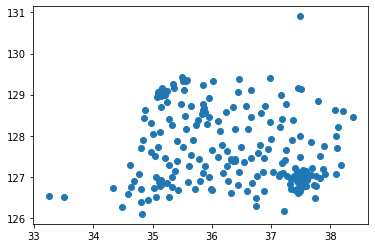

In [115]:
cnee_location

plt.scatter(x = cnee_location["latitude"], y= cnee_location["longitude"])

In [121]:
kms1.fit(cnee_location)
cnee_location["result1"] = kms1.predict(cnee_location)

In [122]:
kms2.fit(cnee_location)
cnee_location["result2"] = kms2.predict(cnee_location)

In [123]:
kms3.fit(cnee_location)
cnee_location["result3"] = kms3.predict(cnee_location)


In [124]:
kms4.fit(cnee_location)
cnee_location["result4"] = kms4.predict(cnee_location)


<AxesSubplot:xlabel='latitude', ylabel='longitude'>

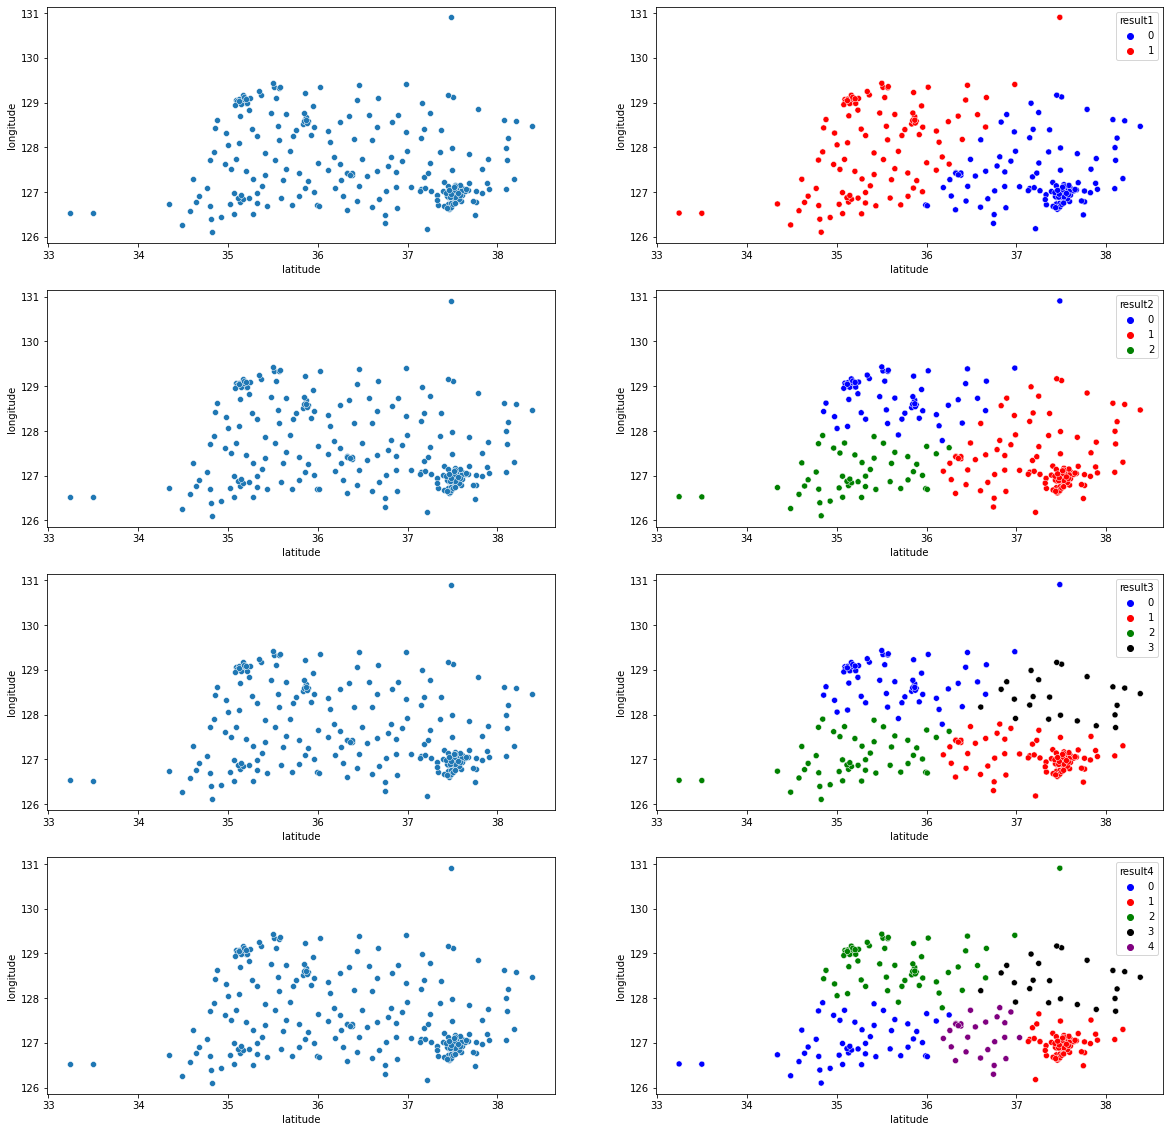

In [125]:
fig, axes = plt.subplots(nrows = 4, ncols= 2, figsize=(20, 20))



sns.scatterplot(x = 'latitude', y = 'longitude', data = cnee_location, ax = axes[0][0])
sns.scatterplot(x = 'latitude', y = 'longitude', hue="result1", palette=["blue", "red"], data = cnee_location, ax = axes[0][1])

sns.scatterplot(x = 'latitude', y = 'longitude', data = cnee_location, ax = axes[1][0])
sns.scatterplot(x = 'latitude', y = 'longitude', hue="result2", palette=["blue", "red", "green"], data = cnee_location, ax = axes[1][1])

sns.scatterplot(x = 'latitude', y = 'longitude', data = cnee_location, ax = axes[2][0])
sns.scatterplot(x = 'latitude', y = 'longitude', hue="result3", palette=["blue", "red", "green", "black"], data = cnee_location, ax = axes[2][1])

sns.scatterplot(x = 'latitude', y = 'longitude', data = cnee_location, ax = axes[3][0])
sns.scatterplot(x = 'latitude', y = 'longitude', hue="result4", palette=["blue", "red", "green", "black", "purple"], data = cnee_location, ax = axes[3][1])

In [126]:
f = folium.Figure(width=1000, height=700)
m = folium.Map(width = 1000, height = 700, location = [37.4292, 126.9874], zoom_start = 7)
minimap = plugins.MiniMap()

cluster_number = folium.FeatureGroup(name='all_point')
cluster_2 = plugins.FeatureGroupSubGroup(cluster_number, 'cluster_2')
cluster_3 = plugins.FeatureGroupSubGroup(cluster_number, 'cluster_3')
cluster_4 = plugins.FeatureGroupSubGroup(cluster_number, 'cluster_4')
cluster_5 = plugins.FeatureGroupSubGroup(cluster_number, 'cluster_5')

m.add_child(cluster_number)
m.add_child(cluster_2)
m.add_child(cluster_3)
m.add_child(cluster_4)
m.add_child(cluster_5)



for i in range(len(cnee_location)):
    if cnee_location["result1"][i] == 0:
        color_ = "blue"
    elif cnee_location["result1"][i] == 1:   
        color_ = "red"
    elif cnee_location["result1"][i] == 2:   
        color_ = "green"
    elif cnee_location["result1"][i] == 3:   
        color_ = "black"                
    elif cnee_location["result1"][i] == 4:   
        color_ = "purple"

    receiver = [cnee_location["latitude"][i], cnee_location["longitude"][i]]
    folium.Circle(location = receiver, radius = 50, color = color_, fill=True).add_to(cluster_2)

for i in range(len(cnee_location)):
    if cnee_location["result2"][i] == 0:
        color_ = "blue"
    elif cnee_location["result2"][i] == 1:   
        color_ = "red"
    elif cnee_location["result2"][i] == 2:   
        color_ = "green"
    elif cnee_location["result2"][i] == 3:   
        color_ = "black"                
    elif cnee_location["result2"][i] == 4:   
        color_ = "purple"

    receiver = [cnee_location["latitude"][i], cnee_location["longitude"][i]]
    folium.Circle(location = receiver, radius = 50, color = color_, fill=True).add_to(cluster_3)

for i in range(len(cnee_location)):
    if cnee_location["result3"][i] == 0:
        color_ = "blue"
    elif cnee_location["result3"][i] == 1:   
        color_ = "red"
    elif cnee_location["result3"][i] == 2:   
        color_ = "green"
    elif cnee_location["result3"][i] == 3:   
        color_ = "black"                
    elif cnee_location["result3"][i] == 4:   
        color_ = "purple"

    receiver = [cnee_location["latitude"][i], cnee_location["longitude"][i]]
    folium.Circle(location = receiver, radius = 50, color = color_, fill=True).add_to(cluster_4)

for i in range(len(cnee_location)):
    if cnee_location["result4"][i] == 0:
        color_ = "blue"
    elif cnee_location["result4"][i] == 1:   
        color_ = "red"
    elif cnee_location["result4"][i] == 2:   
        color_ = "green"
    elif cnee_location["result4"][i] == 3:   
        color_ = "black"                
    elif cnee_location["result4"][i] == 4:   
        color_ = "purple"

    receiver = [cnee_location["latitude"][i], cnee_location["longitude"][i]]
    folium.Circle(location = receiver, radius = 50, color = color_, fill=True).add_to(cluster_5)

folium.LayerControl(collapsed=False).add_to(m)
f.add_child(m)

In [127]:
print(e_commerce_fc_data[(e_commerce_fc_data["송화인터미널"] == "세종특별자치시 nan") & (e_commerce_fc_data["고객사코드"] == 90001302)]["고객사코드"].count())
print(e_commerce_fc_data[(e_commerce_fc_data["송화인터미널"] == "세종특별자치시 nan") & (e_commerce_fc_data["고객사코드"] == 90001776)]["고객사코드"].count())

0
0


In [128]:
code_list = list(e_commerce_fc_data["고객사코드"].unique())

f = folium.Figure(width=1000, height=700)
m = folium.Map(width = 1000, height = 700, location = [37.4292, 126.9874], zoom_start = 7)

code_point = folium.FeatureGroup(name = "code_point", show=True)

m.add_child(code_point)

code_point_list = []
show_=True

for i in code_list:
    code_point_ = str(i)[4:]

    globals()[code_point_] = plugins.FeatureGroupSubGroup(code_point, code_point_ , show=show_)
    show_ = False
    code_point_list.append(globals()[code_point_])

# print(postzone1)
for i in code_point_list:
    m.add_child(i)

for i in range(len(code_list)):
    target_df = e_commerce_fc_data[e_commerce_fc_data["고객사코드"] == code_list[i]]

    target_set = set()
    for j in range(len(target_df)):
        target_set.add( (target_df["SHPR_ADDR_LATITUDE"][j], target_df["SHPR_ADDR_LONGITUDE"][j]) )

    for k in range(len(list(target_set))):
        sender = list(target_set)[k]
        folium.Circle(location = sender, radius = 50, color = "red", fill = True).add_to(code_point_list[i])

folium.LayerControl(collapsed=False).add_to(m)

f.add_child(m)